In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import theano.tensor as tt

In [14]:
import scipy

In [2]:
az.style.use("arviz-darkgrid")
iris = sns.load_dataset('iris')

In [3]:
priors = {"common": bmb.Prior("Normal", mu=0, sigma=2)}
model = bmb.Model(
    "species ~ sepal_length + sepal_width + petal_length + petal_width", 
    iris, 
    family="categorical",
    priors=priors
)
idata = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [petal_width, petal_length, sepal_width, sepal_length, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.


asdasdasd


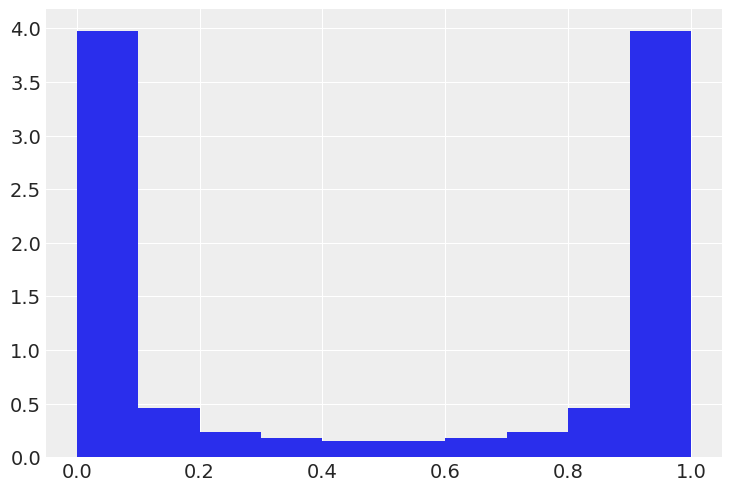

In [4]:
model.predict(idata)

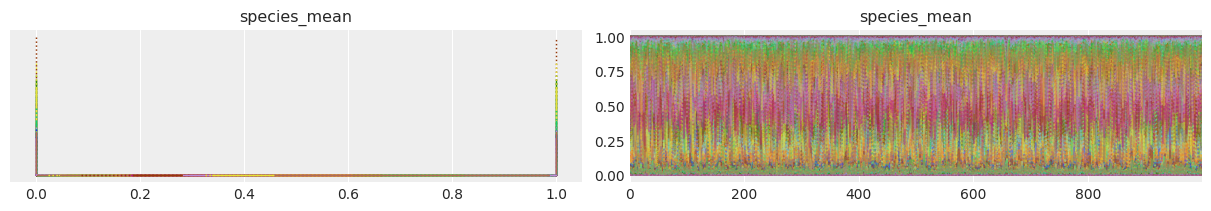

In [5]:
az.plot_trace(idata, var_names=["species_mean"]);

In [7]:
az.summary(idata, var_names=["species_mean"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"species_mean[versicolor, 0]",1.000,0.000,1.000,1.000,0.000,0.000,1073.0,1048.0,1.0
"species_mean[versicolor, 1]",1.000,0.000,1.000,1.000,0.000,0.000,1030.0,1032.0,1.0
"species_mean[versicolor, 2]",1.000,0.000,1.000,1.000,0.000,0.000,1045.0,1083.0,1.0
"species_mean[versicolor, 3]",1.000,0.000,1.000,1.000,0.000,0.000,1042.0,1068.0,1.0
"species_mean[versicolor, 4]",1.000,0.000,1.000,1.000,0.000,0.000,1089.0,1092.0,1.0
...,...,...,...,...,...,...,...,...,...
"species_mean[virginica, 145]",0.956,0.043,0.878,0.999,0.001,0.001,1823.0,1564.0,1.0
"species_mean[virginica, 146]",0.815,0.108,0.600,0.970,0.003,0.002,1846.0,1852.0,1.0
"species_mean[virginica, 147]",0.901,0.053,0.798,0.982,0.001,0.001,1939.0,1638.0,1.0
"species_mean[virginica, 148]",0.983,0.020,0.950,1.000,0.001,0.000,2166.0,1595.0,1.0


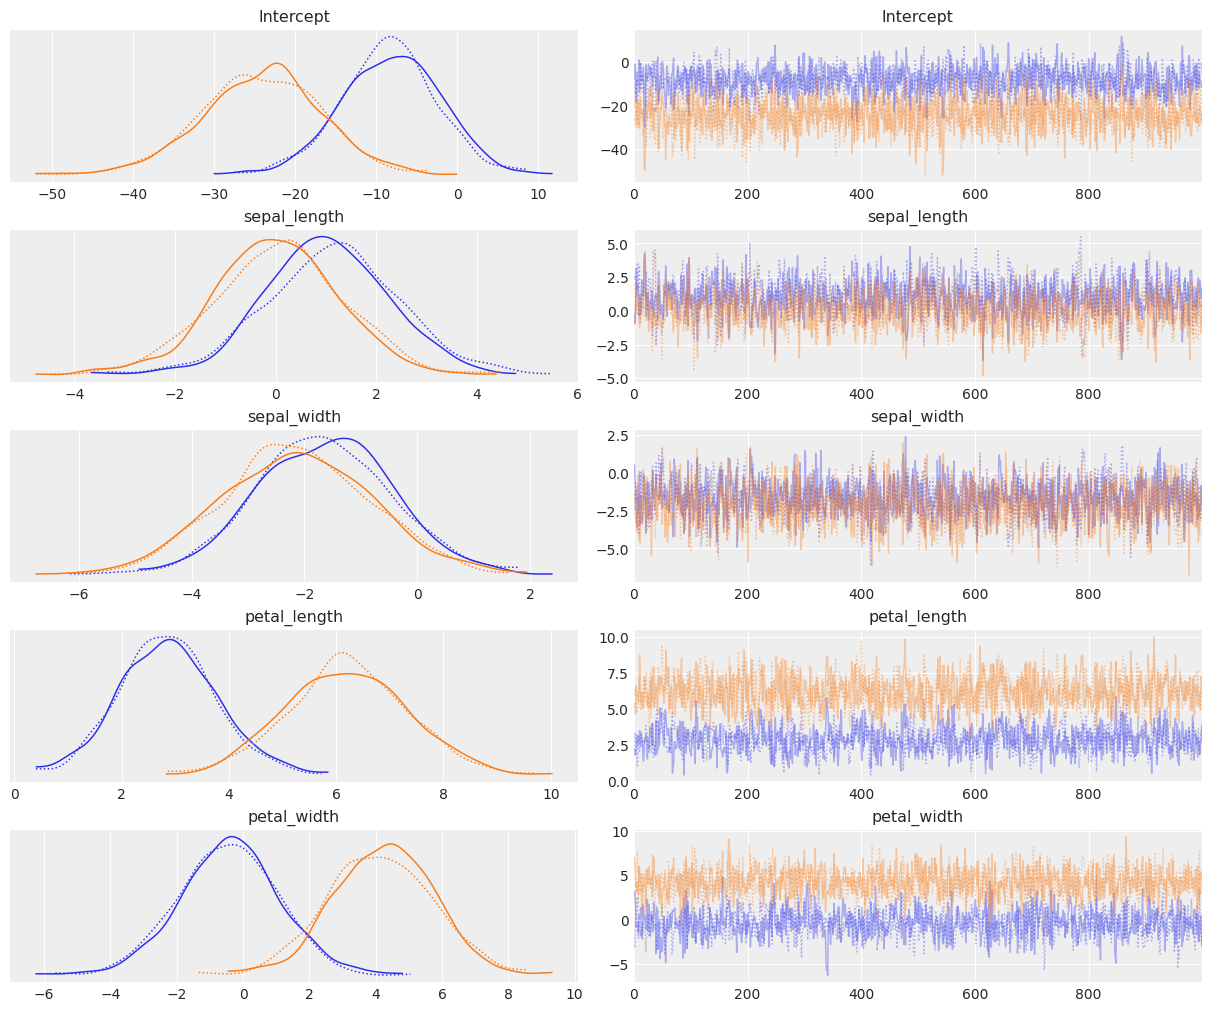

In [8]:
az.plot_trace(idata, var_names="~species_mean");

In [8]:
sample_coords = ["chain", "draw", "species_coord"]
posterior = idata.posterior.stack(sample=sample_coords)

In [9]:
X = model._design.common.design_matrix

In [12]:
beta_x_list = [np.atleast_2d(posterior[name]) for name in model.common_terms]
beta_x_list.insert(0, np.atleast_2d(posterior["Intercept"]))
beta_x = np.vstack(beta_x_list)
linear_predictor = np.dot(X, beta_x)
linear_predictor.shape

(150, 4000)

In [15]:
scipy.special.softmax(linear_predictor)

array([[6.26662463e-20, 2.13369019e-28, 8.59859934e-19, ...,
        7.13526255e-26, 6.98976424e-20, 4.12185297e-28],
       [2.93253132e-19, 1.74957119e-27, 8.16228584e-19, ...,
        1.77567996e-25, 5.85661476e-20, 9.47812456e-28],
       [9.80613866e-20, 6.25751070e-28, 4.11966087e-19, ...,
        6.69863688e-26, 3.10235195e-20, 3.02548302e-28],
       ...,
       [4.31561384e-15, 5.09348176e-14, 4.65798752e-14, ...,
        4.57345374e-12, 1.77424027e-12, 2.33713234e-11],
       [1.30409262e-15, 3.54041686e-13, 2.63843308e-14, ...,
        3.13869827e-11, 3.17700275e-12, 2.55646522e-10],
       [1.72915186e-15, 2.20094159e-14, 2.48602807e-14, ...,
        6.96963028e-13, 4.58478644e-13, 2.27432990e-12]])

In [16]:
sample_shape = (2, 1000, 2, 150)

In [17]:
lp = linear_predictor.reshape(sample_shape)
lp.shape

(2, 1000, 2, 150)

In [19]:
model.response.data.shape

(150, 1)

(array([3.9637    , 0.4671    , 0.23893333, 0.17655   , 0.15371667,
        0.15371667, 0.17655   , 0.23893333, 0.4671    , 3.9637    ]),
 array([4.7671913e-14, 1.0000000e-01, 2.0000000e-01, 3.0000000e-01,
        4.0000000e-01, 5.0000000e-01, 6.0000000e-01, 7.0000000e-01,
        8.0000000e-01, 9.0000000e-01, 1.0000000e+00]),
 <BarContainer object of 10 artists>)

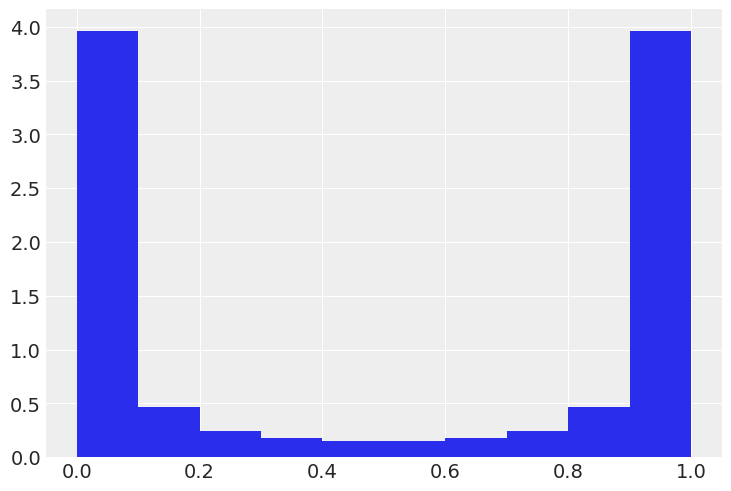

In [23]:
plt.hist(scipy.special.softmax(lp, axis=2).flatten(),density=True)

array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'sepal_length'}>,
        <AxesSubplot:title={'center':'sepal_length'}>],
       [<AxesSubplot:title={'center':'sepal_width'}>,
        <AxesSubplot:title={'center':'sepal_width'}>],
       [<AxesSubplot:title={'center':'petal_length'}>,
        <AxesSubplot:title={'center':'petal_length'}>],
       [<AxesSubplot:title={'center':'petal_width'}>,
        <AxesSubplot:title={'center':'petal_width'}>]], dtype=object)

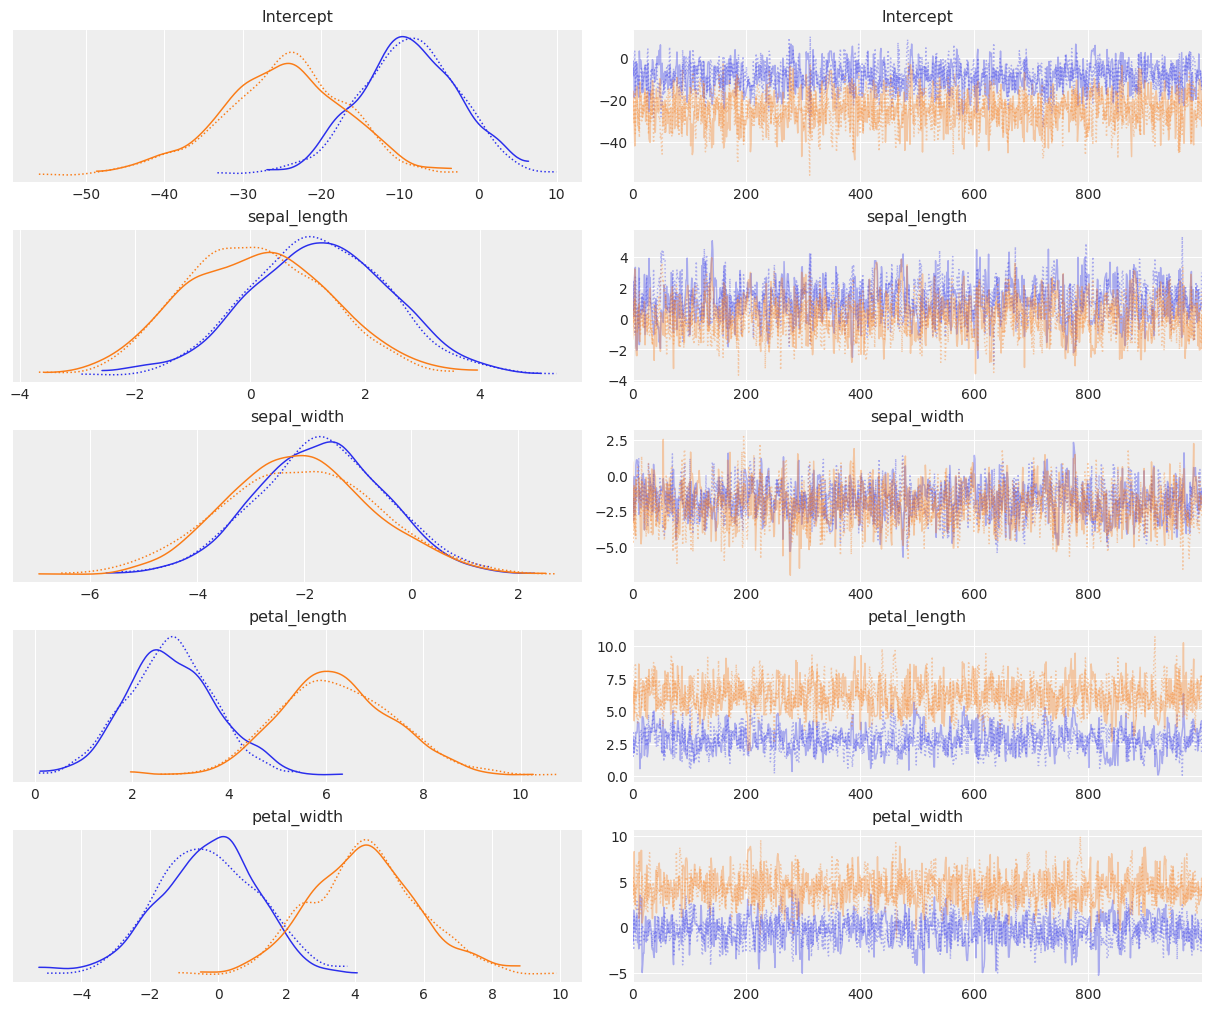

In [5]:
az.plot_trace(idata)
fig = plt.gcf()
fig.savefig("posterior.png")

In [6]:
y_s = pd.Categorical(iris['species']).codes
x_n = iris.columns[:-1]
X = iris[x_n].values
X = X - X.mean(axis=0)
X = np.hstack([np.ones((150, 1)), X])

In [7]:
coords = {"species": ["versicolor", "virginica"]}
with pm.Model(coords=coords) as model_sf:
    β0 = pm.Normal('β0', mu=0, sd=2, dims="species")[None, :]
    β_sl = pm.Normal('β_sl', mu=0, sd=2, dims="species")[None, :]
    β_sw = pm.Normal('β_sw', mu=0, sd=2, dims="species")[None, :]
    β_pl = pm.Normal('β_pl', mu=0, sd=2, dims="species")[None, :]
    β_pw = pm.Normal('β_pw', mu=0, sd=2, dims="species")[None, :]
    
    β = tt.concatenate([β0, β_sl, β_sw, β_pl, β_pw])
    μ = tt.concatenate([np.zeros((150, 1)), pm.math.dot(X, β)], axis=1)
    p = tt.nnet.softmax(μ)

    yl = pm.Categorical('yl', p=p, observed=y_s)

    idata_pm = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β_pw, β_pl, β_sw, β_sl, β0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.


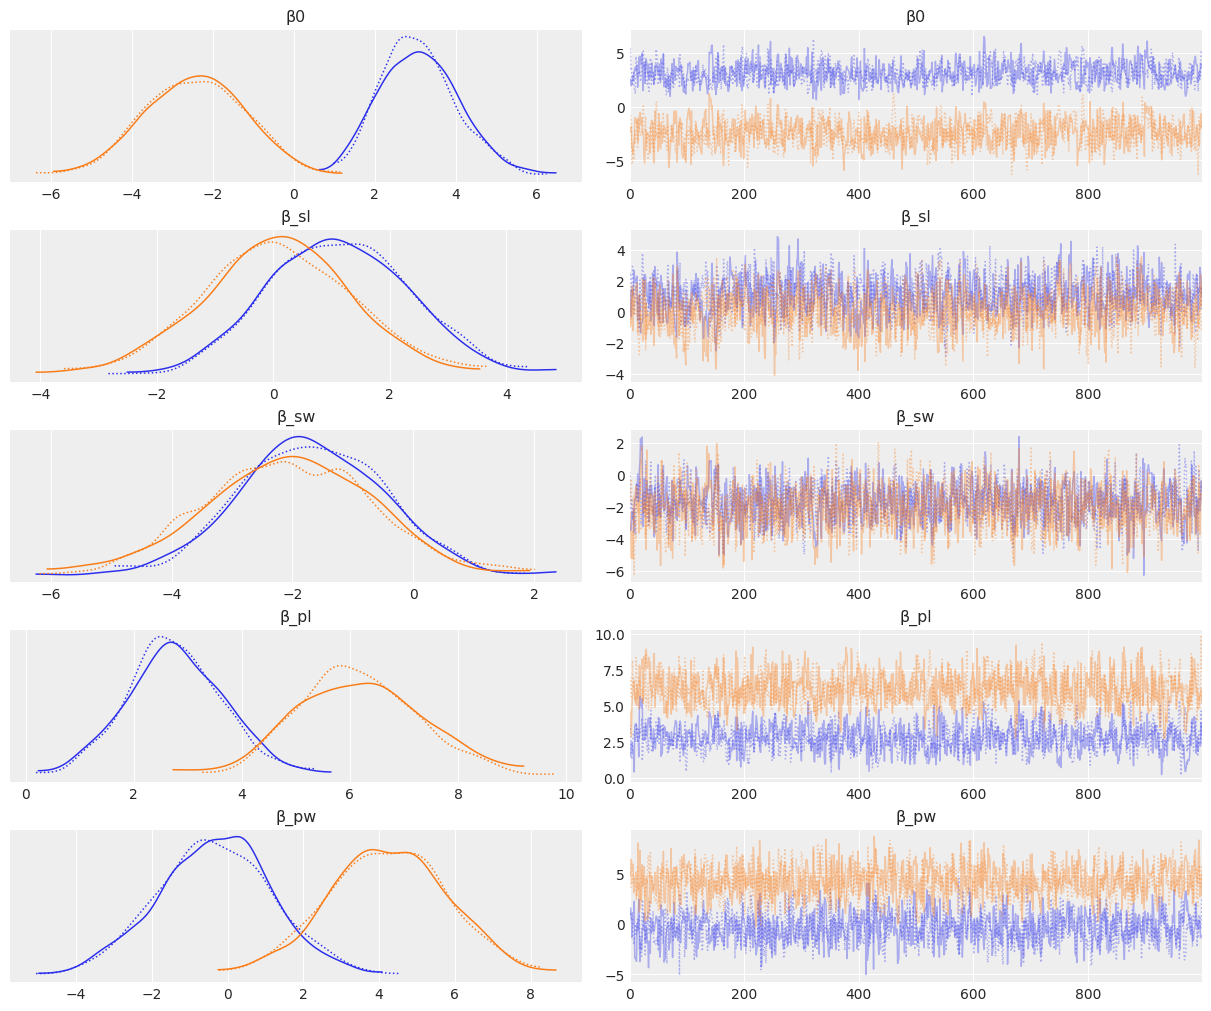

In [8]:
az.plot_trace(idata_pm)
fig = plt.gcf()
fig.savefig("posterior_pymc.png")